In [1]:
import matplotlib.pyplot as plt

In [2]:
import torch

In [3]:
import pyro

In [4]:
pyro.set_rng_seed(101)

In [5]:
loc = 0.
scale = 1.
normal = torch.distributions.Normal(loc, scale)
x = normal.rsample()
print(f"Sample: {x}")

Sample: -1.3905061483383179


In [6]:
x = pyro.sample("my_sample", pyro.distributions.Normal(loc, scale))
print(x)

tensor(-0.8152)


# simple weather model

In [7]:
import pyro.distributions as dist

def weather():
    cloudy = pyro.sample('cloudy', dist.Bernoulli(0.3))
    cloudy = 'cloudy' if cloudy.item() == 1.0 else 'sunny'
    mean_temp = {'cloudy': 55.0, 'sunny': 75.0}[cloudy]
    scale_temp = {'cloudy': 10.0, 'sunny': 15.0}[cloudy]
    temp = pyro.sample('temp', dist.Normal(mean_temp, scale_temp))
    return cloudy, temp.item()

In [8]:
for _ in range(3):
    print(weather())

('cloudy', 64.5440444946289)
('sunny', 94.37557983398438)
('sunny', 72.5186767578125)


In [9]:
def ice_cream_sales():
    cloudy, temp = weather()
    expected_sales = 200. if cloudy=='sunny' and temp > 80. else 50.
    ice_cream = pyro.sample('ice_cream', pyro.distributions.Normal(expected_sales, 10.))
    return ice_cream

In [10]:
ice_cream_sales()

tensor(44.2723)

# Inference

sample dist(observation, weight)

In [11]:
def scale(guess):
    weight = pyro.sample('weight', dist.Normal(guess, 1.0))
    measurement = pyro.sample('measurement', dist.Normal(weight, 0.75))
    return measurement

scale(14.)

tensor(11.2202)

Change to p(weight | observation)

1. condition the model

In [12]:
# pyro condition is like partial function evaluation, but we pre-determine the outcome of one of the sampling
# operations instead of pre-determining the value of one of the arguments
conditioned_scale = pyro.condition(scale, {'measurement': torch.tensor(14.)})

2. set the prior and infer the posterior (HMC and NUTS)

In [13]:
from pyro.infer import NUTS, MCMC, EmpiricalMarginal

guess_prior = torch.tensor(13.)

nuts_kernel = NUTS(conditioned_scale, adapt_step_size=True)
posterior = MCMC(nuts_kernel, num_samples=1_000, warmup_steps=300)
posterior.run(guess_prior)
marginal = posterior.get_samples()['weight'] # get_samples returns a dictionary kekyed by the site name

Sample: 100%|██████████| 1300/1300 [00:02, 451.95it/s, step size=8.31e-01, acc. prob=0.942]


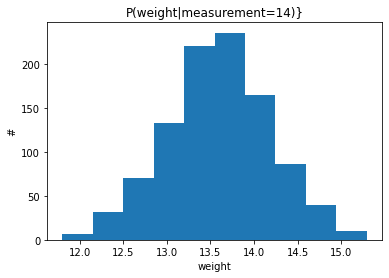

In [14]:
plt.hist(marginal)
plt.title("P(weight|measurement=14)}")
plt.xlabel('weight')
plt.ylabel('#')
print(posterior)

In [15]:
d = dist.MultivariateNormal(torch.zeros(3), torch.eye(3,3)).expand([5])
# expand - 3 of these multivariate normal dists
print(f"batch shape: {d.batch_shape}")
print(f"event_shape: {d.event_shape}")

batch shape: torch.Size([5])
event_shape: torch.Size([3])


In [16]:
#x = d.sample(torch.Size([5]))
x = d.sample()
print(f"x shape: {x.shape}") # == sample_shape + batch_shape + event_shape
print("d.log_prob(x) shape: ", d.log_prob(x).shape) # == batch_shape

x shape: torch.Size([5, 3])
d.log_prob(x) shape:  torch.Size([5])


`plate` context manager

In [17]:
def model():
    burglar = pyro.sample("B", dist.Categorical(torch.tensor([0.999, 0.001]))) 
    earthquake = pyro.sample("E", dist.Categorical(torch.tensor([0.998, 0.002])))
    alarm_probs = torch.tensor([[[0.999, 0.001],[0.71,0.29]],[[0.06, 0.94],[0.05, 0.95]]])
    alarm = pyro.sample("A", dist.Categorical(alarm_probs[burglar][earthquake]))
    john_probs = torch.tensor([[0.95, 0.05], [0.1, 0.9]])
    mary_probs = torch.tensor([[0.99, 0.01], [0.3, 0.7]])
    john_calls = pyro.sample("J", dist.Categorical(john_probs[alarm]))
    mary_calls = pyro.sample("M", dist.Categorical(mary_probs[alarm]))

lets say we know that thte alarm went off (alarm = 1) and Mary called. Can we use the model to infer about the possibility of an earthquake?

In [18]:
# condition on the model with observation/evidence
conditioned_model = pyro.condition(model, data = {'M': torch.tensor(1), 'A': torch.tensor(1)})

Perform posterior inference using Importance Sampling

In [19]:
posterior = pyro.infer.Importance(conditioned_model, num_samples=1000).run()

In [20]:
# get the marginal distribution of the variable we are interesed in )In our case earthquake.
marginal = pyro.infer.EmpiricalMarginal(posterior, "E")

In [21]:
marginal

EmpiricalMarginal()

In [22]:
import numpy as np

In [23]:
earthquake_samples = np.array([marginal().item() for _ in range(1000)])

In [24]:
e_unique, e_counts = np.unique(earthquake_samples, return_counts=True)

Text(0.5, 1.0, 'Earthquake|Alarm=On, Mary Called')

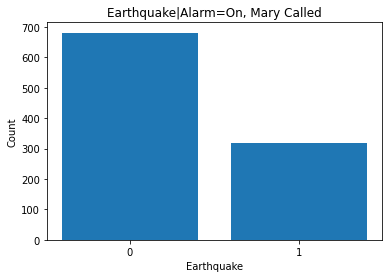

In [25]:

plt.xlabel("Earthquake")
plt.ylabel("Count")
plt.bar(e_unique, e_counts)
plt.xticks(e_unique)
plt.title("Earthquake|Alarm=On, Mary Called")

what was the probability there was an earthquake, given alarm went off and Mary called?

In [26]:
print(earthquake_samples.mean())

0.319


# Gaussian Mixture Model

In [66]:
import os
from collections import defaultdict
import numpy as np
import scipy.stats
import torch
from torch.distributions import constraints
from pyro import poutine
from pyro.contrib.autoguide import AutoDelta
from pyro.optim import Adam
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate, infer_discrete
import pyro.distributions as dist

from matplotlib import pyplot

In [67]:
pyro.enable_validation(True)

In [68]:
data = torch.tensor([0., 1., 10., 11., 12.])
K = 2 # fixed number of components

In [69]:
# config_enumerate (configure all guide sites at once)

@config_enumerate
def model(data):
    # Global variables
    
    # weights on each gaussian for mixture?
    weights = pyro.sample('weights', dist.Dirichlet(0.5 * torch.ones(K)))
    # scale of each gaussian for mixture (all the same)
    scale = pyro.sample('scale', dist.LogNormal(0., 2.))
    
    # location of each gaussian for mixture (each different)
    with pyro.plate('components', K):
        locs = pyro.sample('locs', dist.Normal(0., 10.))
    
    # for each data point
    # sample a cluster
    # sample an observation from that cluster
    with pyro.plate('data', len(data)):
        #local variables
        assignment = pyro.sample('assignment', dist.Categorical(weights))
        X = pyro.sample('obs', dist.Normal(locs[assignment], scale))

with pyro.plate("x_axis", 5):
    d = dist.MultivariateNormal(torch.zeros(3), torch.eye(3,3))
    x = pyro.sample('x', d)
x.shape

## continue example

In [58]:
global_guide = AutoDelta(poutine.block(model, expose=['weights', 'locs', 'scale']))
optim = pyro.optim.Adam({'lr': 0.1, 'betas': [0.8, 0.99]})
elbo = TraceEnum_ELBO(max_plate_nesting=1)
svi = SVI(model, global_guide, optim, loss=elbo)

In [59]:
def initialize(seed):
    pyro.set_rng_seed(seed)
    pyro.clear_param_store()
    # Initialize weights to uniform
    pyro.param('auto_weights', 0.5*torch.ones(K), constraint=constraints.simplex)
    # assume half of the data variance is due to intra-component noise
    pyro.param('auto_scale', (data.var() / 2).sqrt(), constraint=constraints.positive)
    # initialize means from a subsample of data
    pyro.param('auto_locs', data[torch.multinomial(torch.ones(len(data))/len(data), K)])
    loss = svi.loss(model, global_guide, data)
    return loss

In [60]:
# choose the best among 100 random initializations
loss, seed = min((initialize(seed), seed) for seed in range(100))
initialize(seed)
print("seed = {}, initial loss = {}".format(seed, loss))

seed = 0, initial loss = 928.9263305664062


In [61]:
# register hooks to monitor gradient norms
gradient_norms = defaultdict(list)
for name, value in pyro.get_param_store().named_parameters():
    value.register_hook(lambda g, name=name: gradient_norms[name].append(g.norm().item()))
losses = []
for i in range(200):
    loss = svi.step(data)
    losses.append(loss)
    print('.' if i % 100 else '\n', end='')


...................................................................................................
...................................................................................................

In [62]:
from matplotlib import pyplot as plt

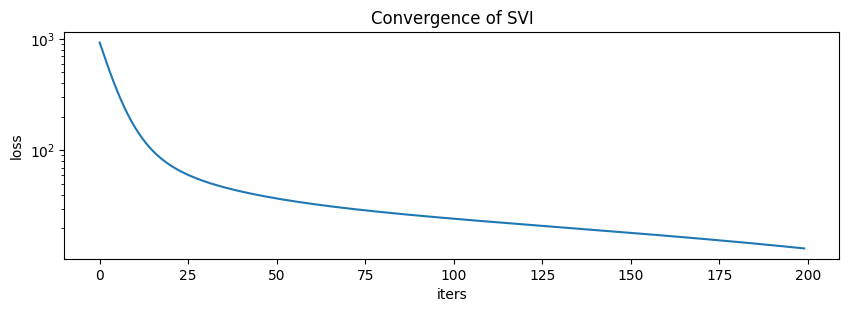

In [63]:
plt.figure(figsize=(10,3), dpi=100).set_facecolor('white')
plt.plot(losses)

plt.ylabel("loss")
plt.yscale('log')
plt.xlabel('iters')
plt.title('Convergence of SVI');

In [64]:
map_estimates = global_guide(data)
weights = map_estimates['weights']
locs = map_estimates['locs']
scale = map_estimates['scale']
print("weights: {}".format(weights.data.numpy()))
print("locs: {}".format(locs.data.numpy()))
print("scale: {}".format(scale.data.numpy()))

weights: [1.0212619e-13 1.0000000e+00]
locs: [1.12033995e-04 2.94428706e+00]
scale: 4.988683223724365


Text(0, 0.5, 'probability density')

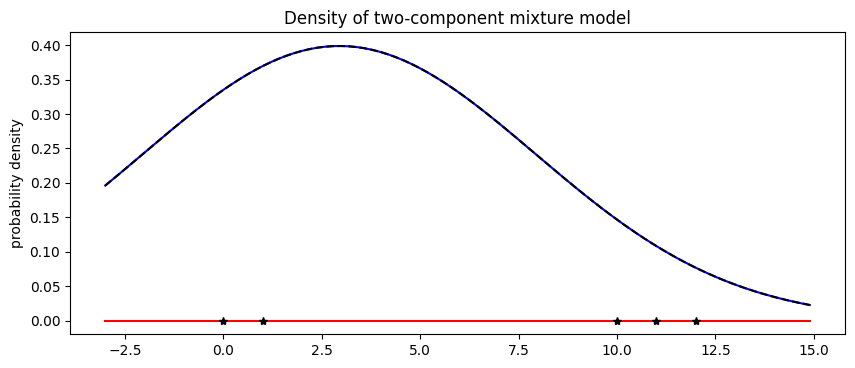

In [65]:
X = np.arange(-3, 15, 0.1)
Y1 = weights[0].item()*scipy.stats.norm.pdf((X - locs[0].item()) / scale.item())
Y2 = weights[1].item()*scipy.stats.norm.pdf((X-locs[1].item())/scale.item())
plt.figure(figsize=(10, 4), dpi=100).set_facecolor('white')
plt.plot(X, Y1, 'r-')
plt.plot(X, Y2, 'b-')
plt.plot(X, Y1 + Y2, 'k--')
plt.plot(data.data.numpy(), np.zeros(len(data)), 'k*')
plt.title('Density of two-component mixture model')
plt.ylabel('probability density')